In [38]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns

## <span style="green:green"> Analysis of BoardGameGeek Data from 2021 and Board Game Preference of Players in my Personal Playgroup</span>
---
First, I found a dataset from BoardGameGeek.com that contained ~20,000 rows of data for board games from 2021 on Kaggle. That dataset can be found [here.](https://www.kaggle.com/datasets/andrewmvd/board-games)

Next, I created a Google Forms survey to gather information from my friends and family. The link to the Google Form can be found [here.](https://forms.gle/xJ2i4NNg1iaMEcCm6) It allowed me to simply collect a dataset of their top 5 board games of all time.

I then spent time cleaning the dataset I collected and added the BoardGameGeek.com ID to the dataset so that I could easily join on a unique identifier.

Then I created a SQLlite database file (the code for which can be found in the CreateSQLdb.ipynb file of this repository) using the cleaned .csv files of both the player dataset and the dataset from Kaggle. The dataset from Kaggle had to have a few interesting parameters since it was semicolon delimited and needed the decimal point notation to be changed from a comma to a decimal point.

Once I created the SQLlite database file I was able to consruct the below SQL query to join my two datasets on the BoardGameGeek.com ID and begin my analysis.

In [39]:
joined_games_query = ('''
SELECT fg.ID, fg."Player Name", bgg.Name, bgg."Year Published", bgg."Play Time", bgg."BGG Rank", bgg."Rating Average", bgg."Complexity Average", bgg.Mechanics, bgg.Domains, bgg.ID AS BGGID
FROM FavoriteGames AS fg
INNER JOIN bgg_dataset AS bgg ON fg.BGGID = bgg.ID;
''')                        

This next step creates my joined dataframe using the SQL query above and builds the favorite_games_by_player_df dataframe which I began to use to do my initial data analysis.

In [40]:
conn = sqlite3.connect('boardgame_data.db')
favorite_games_by_player_df = pd.read_sql_query(joined_games_query, conn)
favorite_games_by_player_df['Year Published'] = favorite_games_by_player_df['Year Published'].astype(int)
favorite_games_by_player_df['BGGID'] = favorite_games_by_player_df['BGGID'].astype(int)  
#favorite_games_by_player_df['Year Published'] = favorite_games_by_player_df['Year Published'].astype(str)
favorite_games_by_player_df['BGGID'] = favorite_games_by_player_df['BGGID'].astype(str) 
favorite_games_by_player_df.head()

,ID,Player Name,Name,Year Published,Play Time,BGG Rank,Rating Average,Complexity Average,Mechanics,Domains,BGGID
0,13,Ken G.,1817,2010,540,1523,8.75,4.68,"Auction/Bidding, Loans, Market, Network and Ro...",Strategy Games,63170
1,8,Eric M.,1861: The Railways of the Russian Empire,2006,360,2300,7.55,4.21,"Auction/Bidding, Network and Route Building, S...",Strategy Games,23817
2,3,Catherine G.,7 Wonders,2010,30,61,7.75,2.33,"Card Drafting, Drafting, Hand Management, Set ...","Family Games, Strategy Games",68448
3,4,Maurie B.,7 Wonders,2010,30,61,7.75,2.33,"Card Drafting, Drafting, Hand Management, Set ...","Family Games, Strategy Games",68448
4,16,Rex S.,The 7th Continent,2017,1000,34,8.15,2.87,"Cooperative Game, Grid Movement, Hand Manageme...",Thematic Games,180263


### Who likes the highest rated games?
My first data exploration was a simple one. BoardGameGeek.com, or BGG moving forward, allows players to rate board games they have played and then aggregates these ratings to create a Rating Average that appears on their website. Their philosophy for how these ratings are calculated can be found [here.](https://boardgamegeek.com/wiki/page/ratings)


In [41]:
rating_df = favorite_games_by_player_df.groupby('Player Name').aggregate({'Rating Average':'mean'})
rating_df.sort_values(by='Rating Average', ascending=False)


,Rating Average
Player Name,
Joseph P.,8.140
Squire G.,8.082
Brandon T.,8.034
Jacob B.,8.030
Ken G.,8.018
Eric M.,7.956
Randall M.,7.918
Catherine G.,7.912
Erica G.,7.820


As we can see in the dataframe above, Joseph, Squire, and Brandon's favorite games seem to be the highest rated on BGG. 


Next, I wanted to create a visual that showed the breakdown of players and the average rating of their favorite games. Anecdotally, players who aren't as deep into the hobby and aren't as exposed to as many games tended to like games of lower rankings. Generally classic mass market games such as Clue, Monopoly, and Checkers.

Text(0.5, 1.0, 'Average Rating Per Player')

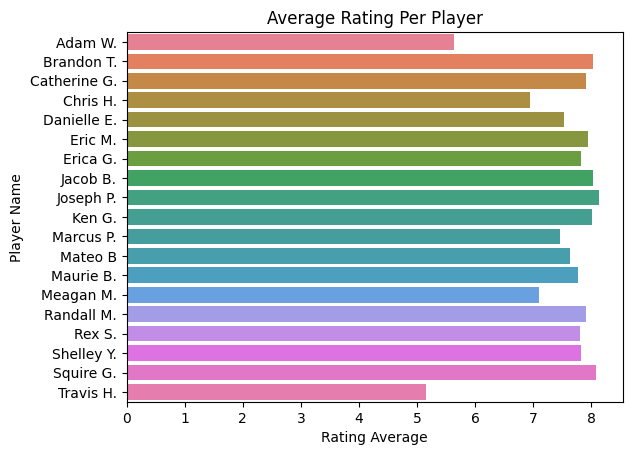

In [42]:
fig1 = sns.barplot(data=rating_df, x='Rating Average', y='Player Name', hue='Player Name', legend='auto')
plt.title("Average Rating Per Player")

### Who likes the "heaviest" games?
...
Next I wanted to explore "weight" among my playgroup. Who likes the "heaviest" or most difficult gaming experiences. BGG has a ranking for this as well that is voted on by users. Their philosophy for Game Play Weight rankings can also be found [here.](https://boardgamegeek.com/wiki/page/ratings)


In [43]:
complexity_df = favorite_games_by_player_df.groupby('Player Name').aggregate({'Complexity Average':'mean'})
complexity_df.sort_values(by='Complexity Average', ascending=False)

,Complexity Average
Player Name,
Ken G.,4.232
Eric M.,4.126
Brandon T.,3.880
Joseph P.,3.708
Squire G.,3.548
Shelley Y.,2.888
Randall M.,2.844
Jacob B.,2.820
Catherine G.,2.778


As we can see on the table above, Ken, Eric, and Brandon lean towards games with a high complexity. Whereas, Meagan, Adam, and Travis prefer "lighter" less complex games.

Again, I created the visualization below to capture this dataset.

Text(0.5, 1.0, 'Complexity Rating Per Player')

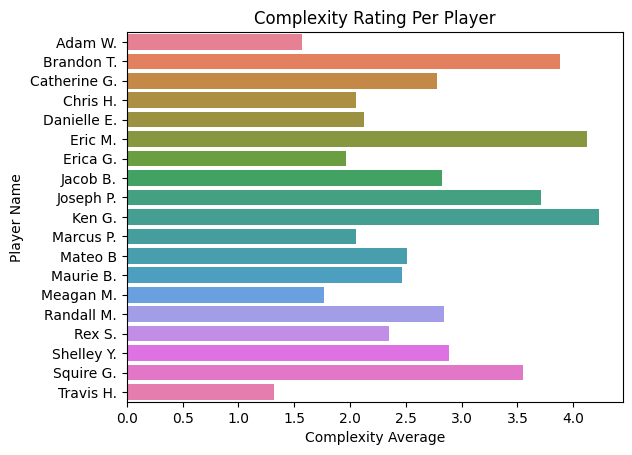

In [44]:
fig2 = sns.barplot(data=complexity_df, x='Complexity Average', y='Player Name', hue='Player Name', legend='auto')
plt.title("Complexity Rating Per Player")

### What game is the most popular?

Next I wanted to create a dataset that showed which games occured most in people's top 5s. So the code below counts the number of mentions of a particular game in the favorite_games_by_player_df and informs us that the games mentioned most as a favorite game are Wingspan, Clue, and Ticket to Ride. The fact that the BGG dataset has over 20,000 games to choose form informs us on the popularity of these titles.

In [45]:
popular_game_df = favorite_games_by_player_df['Name'].value_counts().sort_values(ascending=False).reset_index(name="Counts")
total_top_5 = popular_game_df.head(5)
total_top_5


,Name,Counts
0,Wingspan,6
1,Clue,3
2,Ticket to Ride,3
3,Splendor,2
4,Brass: Lancashire,2


Next, I wanted to create a visualization that showed the overall top five games for our particular playgroup and what percentage each title has in the overall top 5. 

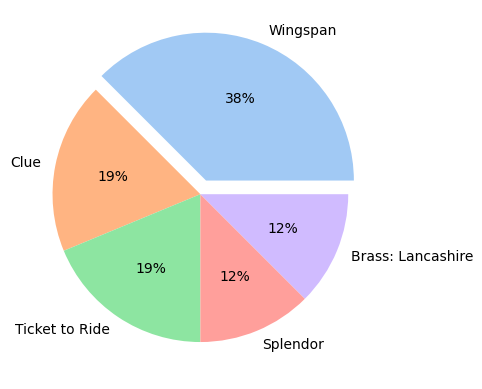

In [54]:
labels = total_top_5['Name']
data = total_top_5['Counts']
colors = sns.color_palette('pastel')[0:5]
explode = [0.1, 0, 0, 0, 0] 
plt.pie(data, labels=labels, colors=colors, explode=explode, autopct='%.0f%%')
plt.show()

### What are the newest and oldest games my playgroup likes?

Next I wanted to explore the newest and oldest games on our favorite games list. As we can see in the dataframe below, we enjoy several games that we published in 2020 (the board gaming hobby is often accused of having a 'cult of the new' mentality), but the oldest game on in the list is Go, dating back to 2200 BCE.

In [46]:
games_by_year_df = favorite_games_by_player_df.groupby('Name').aggregate({'Year Published':'min'})
games_by_year_df.sort_values(by='Year Published', ascending=False)

,Year Published
Name,
Tidal Blades: Heroes of the Reef,2020
MicroMacro: Crime City,2020
My City,2020
On Mars,2020
Calico,2020
...,...
Sorry!,1929
Crokinole,1876
Cribbage,1630


Continuing this data exploration, I wanted to see what the oldest games each player liked. We can see in the dataframe below Jacob definitely likes the newest games of all the players. His oldest game being from 2016, and Brandon's favorite game Go, again, is the oldest game our group enjoys.

In [47]:
cult_of_the_new_df = favorite_games_by_player_df.groupby('Player Name').aggregate({'Year Published':'min'})
cult_of_the_new_df.sort_values(by='Year Published', ascending=False)

,Year Published
Player Name,
Jacob B.,2016
Shelley Y.,2015
Catherine G.,2010
Maurie B.,2010
Rex S.,2008
Mateo B,2008
Eric M.,2005
Squire G.,2005
Ken G.,2004
